<h1>Compressor de Imagens com perda voltado para imagens de rostos humanos via remoção de traços faciais usando transformadas DCT</h1>
<h5>André Luiz Moreira Dutra - 2019006345 <br> Marcos Vinicius Caldeira Pacheco - 2019006957 </h5>

Compressor voltado pra imagens de rostos humanos, com perda. Para ele, foi considerado imagens que tenham pelo menos uma dimensão de tamanho 1024px, e nenhuma maior que isso. Imagens com uma das dimensões menores terão um padding adicionado para resultar numa imagem 1024x1024 <br>

Foram utilizadas várias imagens do site thispersondoesnotexist.com para criar um "rosto médio" que ajudaria a determinar regiões de mais e menos importância, e assim determinar o grau de compressão dessas regiões.

Imports Iniciais

In [ ]:
import requests
import shutil
import json
import os

import cv2
import numpy as np

import matplotlib.pyplot as plt

Coleta de imagens da API do site thispersondoesnotexist.com

In [ ]:
#Coleta de imagens

faces_number = 10
im_size = 1024

url = 'https://fakeface.rest/face/json'

os.mkdir('faces_{}'.format(im_size))

for i in range(faces_number):
  res = requests.get(url, stream = True)
  if res.status_code != 200:
    continue
  res.raw.decode_content = True
  js = json.load(res.raw)

  res = requests.get(js['image_url'], stream = True)
  if res.status_code != 200:
    continue
  res.raw.decode_content = True
  with open('faces_{}/img{}.png'.format(im_size,i), 'wb') as f:
      res.raw.decode_content = True
      shutil.copyfileobj(res.raw, f)
  img = cv2.imread('faces_{}/img{}.png'.format(im_size,i))
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  cv2.imwrite('faces_{}/img{}.pgm'.format(im_size,i),gray)
  os.remove('faces_{}/img{}.png'.format(im_size,i))

FileExistsError: ignored

Calculando a face média

In [ ]:
#Cálculo das faces médias
os.mkdir('mean_faces')

for im_size in [1024]:
  mean = np.zeros((im_size,im_size))

  n = 0
  for i in range(faces_number):
    im = cv2.imread('faces_{}/img{}.pgm'.format(im_size,i),0)
    im = np.float32(im)/255.0
    a = cv2.dct(im)
    mean+=a
    n+=1
  mean = mean/n
  res_mean = cv2.idct(mean)*255
  cv2.imwrite('mean_faces/mean_face_{}.png'.format(im_size), res_mean)
  np.save('mean_faces/mean_face_dct_{}.npy'.format(im_size), mean)

FileExistsError: ignored

Padding em imagens não quadradas

In [ ]:
def int_to_binstring(i,length):
  mask = 2**length-1
  b = bin(i & mask)[2:]

  if len(b) < length:
    b = '0'*(length - len(b))+b
  return b

def binstring_to_int(bin_str):
  if bin_str[0] == '0':
    return int(bin_str,2)
  else:
    new_str = ''
    for bit in bin_str:
      if bit == '0':
        new_str+='1'
      if bit == '1':
        new_str+='0'
    reversed = int(new_str,2)
    return -reversed-1

In [ ]:
#adiciona bordas para tornar a imagem quadrada
#retorna a imagem quadrada e o cabeçalho indicando o padding feito
#cabeçalho na forma de 1 bit indicando se houve padding, 1 bit indicando se foi horizontal ou vertical e dois ints de 6 bits cada indicando o tamanho da borda adicionada
#OK
def pad(img):
  header = ''
  print(img.shape)
  y,x = img.shape

  if y >= x:
    header+='0'
    diff = y - x
  else:
    header+='1'
    diff = x - y

  pad_size1 = diff//2
  if diff - diff//2 != pad_size1:
    header+='1'
  else:
    header+='0'

  bin1 = int_to_binstring(pad_size1,9)

  header+=bin1

  newImg = img.copy()

  color = 128 #Tom de cinza

  if y > x: #Imagem alta
    ones = np.ones((y, int((y-x)/2)))*color
    newImg = np.concatenate((ones.copy(), np.concatenate((newImg, ones.copy()), axis=1)), axis=1)
    if (y-x)%2 == 1:
      newImg = np.concatenate((newImg, np.ones((y, 1))*color), axis=1)
  else: #Imagem comprida
    ones = np.ones((int((x-y)/2), x))*color
    newImg = np.concatenate((ones.copy(), np.concatenate((newImg, ones.copy()), axis=0)), axis=0)
    if (x-y)%2 == 1:
      newImg = np.concatenate((newImg, np.ones((1, x))*color), axis=0)
  newImg = np.float32(newImg)
  return newImg, header

#faz a dct na imagem e substrai a dct da média de rostos da dct da imagem
#a dct da média é pré-definida e fica no conversor, não precisa ser enviada
#retorna a matriz de erros resultante e o cabeçalho indicando o tamanho da imagem
#O cabeçalho deve conter 10bits contendo o tamanho da imagem usada entre 1 e 1024 OK
def transform_subtract(img):
  im_size = len(img)
  im_normalized = np.float32(img)/255.0

  transformed = cv2.dct(im_normalized)
  face = np.load('mean_faces/mean_face_dct_{}.npy'.format(im_size))
  subtracted = transformed - face

  bin1 = int_to_binstring(im_size-1,10)
  print('imsize: '+bin1)
  return subtracted, bin1

In [ ]:
from heapq import heappush, heappop, heapify
from collections import defaultdict

#passa a matriz de quantização na imagem para jogar os coeficientes pra zero e arredonda os valores (talvez?)
#TODO: testar matrizes de quantização diferentes pra matriz resultante da subtração
#Acho que não precisa de cabeçalho já que o tamanho da imagem já foi definido e a matriz é fixa por tamanho
def quantization(img):
  n = 300
  img*=n
  return np.int32(np.round(img))

#Cria o dicionário de probabilidades do histograma da imagem
#faz o huffman no mapeamento
#retorna o dicionário mapeando cada valor da imagem pro novo pós huffman e o cabeçalho indicando o mapeamento OK
def huffman(img):
  symb2freq = defaultdict(float)
  for val in img.flatten():
    symb2freq[val]+=1
  total = sum(symb2freq.values())
  for k in symb2freq.keys():
    symb2freq[k]/=total

  heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
  heapify(heap)
  while len(heap) > 1:
    lo = heappop(heap)
    hi = heappop(heap)
    for pair in lo[1:]:
      pair[1] = '0' + pair[1]
    for pair in hi[1:]:
      pair[1] = '1' + pair[1]
    heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

  result = sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

  result_dict = {item[0]:item[1] for item in result}
  print(len(result))
  bin1 = bin(len(result))[2:]
  if len(bin1) < 9:
    bin1 = '0'*(9 - len(bin1))+bin1

  bin2 = ''
  mask = 0xffffffff
  for key,val in result_dict.items():
    k_bin = bin(key & mask)[2:]
    if len(k_bin) < 32:
      k_bin = '0'*(32 - len(k_bin))+k_bin
    v_bin = val
    if len(v_bin) < 32:
      v_bin = '0'*(32 - len(v_bin))+v_bin
    bin2+=k_bin+v_bin
  print(bin2)
  return result_dict, bin1, bin2

In [ ]:
#Recebe a imagem inicial e faz o encoding completo
#Primeiro faz o padding, depois a tranformação e subtração, depois a quantização
#por fim faz o huffman e codifica os valores da imagem no huffman obtido
#concatena todos os cabeçalhos com a imagem codificada e salva o arquivo no nome escolhido

teste=0
def encode(img_path, comp_path):
  global teste
  img = cv2.imread(img_path,0)
  padded, cab1 = pad(img)
  transf, cab2 = transform_subtract(padded)
  quant = quantization(transf)

  huff, cab3, cab_map = huffman(quant)
  cab4 = '0000000000'
  huff_encode = [huff[simb] for simb in quant.flatten()]
  all_parts = ['1',cab1,cab2,cab3,cab4,cab_map] + huff_encode

  code_len = len(''.join(all_parts))

  offset = (-code_len) % 8
  offset_bin = int_to_binstring(offset,3)

  code_len += offset

  cab4 = offset_bin + '0000000'

  all_parts[4] = cab4

  bytes_len = int(code_len/8)
  code_len_bytes = (-bytes_len).to_bytes(4,'big',signed=True)

  code = ''.join(all_parts)
  print(code[-50:])
  bytecode = binstring_to_int(code)
  bytecode = bytecode.to_bytes(int(code_len/8), 'big',signed=True)
  teste = binstring_to_int(code)
  with open(comp_path,'wb') as f:
    f.write(code_len_bytes)
    f.write(bytecode)


In [ ]:
def comp_2(bin_str):
  if bin_str[0] == '0':
    return int(bin_str,2)
  else:
    new_str = ''
    for bit in bin_str:
      if bit == '0':
        new_str+='1'
      if bit == '1':
        new_str+='0'
    reversed = int(new_str,2)
    return -reversed-1

#Interpreta os primeiros 40 bits do cabeçalho
def read_header(compressed_string):
  horizontal = bool(int(compressed_string[0],2))
  odd        = bool(int(compressed_string[1],2))
  pad_size   =      int(compressed_string[2:11],2)
  im_size    =      int(compressed_string[11:21],2)+1
  print('im_size: '+compressed_string[11:21])
  huff_size  =      int(compressed_string[21:30],2)
  offset     =      int(compressed_string[30:33],2)

  return horizontal, odd, pad_size, im_size, huff_size, offset

#Decodifica o mapeamento huffman OK
def read_huffman(compressed_string, huff_size):
  huffman_str = compressed_string[:huff_size*32*2]
  huffman_vals = [huffman_str[i:i+32] for i in range(0, huff_size*32*2, 32)]

  huffman = dict()
  for i in range(0,huff_size*2,2):
    huff_code = huffman_vals[i+1]
    huff_code = bin(int(huff_code,2))[2:]
    original  = huffman_vals[i]
    huffman[huff_code] = binstring_to_int(original)
  return huffman

#Retira as bordas adicionadas na imagem dado o tamanho da borda e a orientação (False denota vertical)
#retorna a imagem sem as bordas OK
def unpad(img, pad_size, odd = False, horizontal = True):
  pad_size1 = pad_size
  pad_size2 = pad_size + (1 if odd else 0)
  newImg = img.copy()
  if(horizontal):
    newImg = newImg[pad_size1:len(img)-pad_size2]
  else:
    newImg = newImg.T
    newImg = newImg[pad_size1:len(img)-pad_size2]
    newImg = newImg.T
  return newImg

#Soma a dct média de rostos e desfaz a dct, dado o tamanho da imagem
#Retorna a imagem resultante da detransformação OK
def sum_invtransform(subtracted, im_size):
  face = np.load('mean_faces/mean_face_dct_{}.npy'.format(im_size))
  transformed = subtracted + face
  img = np.int32(np.around(cv2.idct(transformed)*255))
  return img

In [ ]:
#Desfaz a quantização
def rev_quantization(img,im_size):
  return np.float32(img)/300

In [ ]:
#Recebe a imagem codificada
#Extrai os bits do cabeçalho e interpreta
#Primeiro desfaz o huffman, depois desquantiza
#Depois soma a imagem média, desfaz a dct e tira o padding
#salva a imagem no arquivo de nome escolhido
def decode(comp_path, img_path):
  global teste

  with open(comp_path,'rb') as f:
    byte_len = f.read(4)
    code_len = -int.from_bytes(byte_len,'big',signed=True)
    bytecode = f.read(code_len)

  code = int_to_binstring(int.from_bytes(bytecode, 'big'), 8*code_len)
  print(code[:50])
  code = code[2:]
  print(code[-50:])
  horizontal, odd, pad_size, im_size, huff_size, offset = read_header(code[:40])
  huff_size = 1160
  print(horizontal, odd, pad_size, im_size, huff_size, offset)
  code = code[40:]
  code = code[:-offset]
  huffman = read_huffman(code, huff_size)
  code = code[32*2*huff_size:]

  result_image = []
  symb = ''
  n=0
  for bit in code:
    symb+=bit

    if symb in huffman.keys():
      print(symb)
      result_image.append(huffman[symb])
      symb = ''

  result_image = np.array(result_image).reshape((im_size,im_size))
  result_image = rev_quantization(result_image, im_size)
  result_image = sum_invtransform(result_image, im_size)
  result_image = unpad(result_image, pad_size, odd, horizontal)

  cv2.imwrite(img_path, result_image)

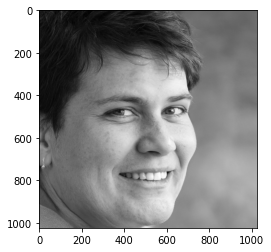

(1024, 1024)
imsize: 1111111111
1160
000000000000000000000000000000000000000000000000000000000000000111111111111111111111111111111111000000000000000000000000000001110000000000000000000000000000000100000000000000000000000000000110111111111111111111111111111111100000000000000000000000000000100100000000000000000000000000000010000000000000000000000000000010100000000000000000000000000000001100000000000000000000000000000000111111111111111111111111111111000000000000000000000000000000010111111111111111111111111111111101000000000000000000000000000101110000000000000000000000000000010000000000000000000000000000000100111111111111111111111111111110100000000000000000000000000000111011111111111111111111111111111011000000000000000000000000001000100000000000000000000000000000010100000000000000000000000000100011000000000000000000000000000001100000000000000000000000000000110000000000000000000000000000000111000000000000000000000000000001001111111111111111111111111111011000000000000000000000000000001010111

ValueError: ignored

In [ ]:
im_path = 'faces_1024/img2.pgm'

im = cv2.imread(im_path)
plt.imshow(im)
plt.show()

encode(im_path,'teste.sla')
decode('teste.sla', 'teste.pgm')

im = cv2.imread('teste.pgm')
plt.imshow(im)
plt.show()

In [ ]:
def huffman(img):
  hist = defaultdict(float)
  for val in img.flatten():
    hist[val]+=1
  total = sum(hist.values())
  for k in hist.keys():
    hist[k]/=total

  symb_table = [(prob, symb, '') for  symb, prob in hist]
  heapify(symb_table)

  while len(symb_table) > 1:


In [ ]:
def huffman(img):
  symb2freq = defaultdict(float)
  for val in img.flatten():
    symb2freq[val]+=1
  total = sum(symb2freq.values())
  for k in symb2freq.keys():
    symb2freq[k]/=total

  heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
  heapify(heap)
  while len(heap) > 1:
    lo = heappop(heap)
    hi = heappop(heap)
    for pair in lo[1:]:
      pair[1] = '0' + pair[1]
    for pair in hi[1:]:
      pair[1] = '1' + pair[1]
    heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

  result = sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

  result_dict = {item[0]:item[1] for item in result}

  bin1 = bin(len(result))[2:]
  if len(bin1) < 9:
    bin1 = '0'*(9 - len(bin1))+bin1

  bin2 = ''
  mask = 0xffffffff
  for key,val in result_dict.items():
    k_bin = bin(key & mask)[2:]
    if len(k_bin) < 32:
      k_bin = '0'*(32 - len(k_bin))+k_bin
    v_bin = val
    if len(v_bin) < 32:teams
      v_bin = '0'*(32 - len(v_bin))+v_bin
    bin2+=k_bin+v_bin
  return result_dict, bin1, bin2

In [ ]:
d,c1,c2 = huffman(np.array([1,1,1,2,2,3,4,5]))
len(c2)

In [ ]:
read_huffman(c2,len(d))